In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon, box

In [2]:
def load_geodataframes(file_paths):
    """Charge plusieurs fichiers CSV en GeoDataFrames et les stocke dans un dictionnaire."""
    geodfs = {}
    for name, file_path in file_paths.items():
        df = pd.read_csv(file_path)
        gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))
        gdf.set_crs(epsg=2056, inplace=True)
        geodfs[name] = gdf
    return geodfs

In [3]:
def merge_geodataframes(geodfs):
    """Fusionne plusieurs GeoDataFrames en conservant toutes les entrées uniques en utilisant les noms relatifs pour les géométries."""
    # Initialiser avec le premier GeoDataFrame
    merged_gdf = geodfs.pop(next(iter(geodfs)))

   # Fusionner avec une jointure externe (outer join)
    for name, gdf in geodfs.items():
        merged_gdf = merged_gdf.merge(gdf, on='idx', how='outer', suffixes=('', f'_{name}_drop'))

    return merged_gdf

In [4]:
# Dictionnaire des chemins vers vos fichiers CSV avec un nom relatif
file_paths = {
    'alt' : 'data/processed/processed_swiss_grid_altitude.csv', 
    'env' : 'data/processed/processed_swiss_grid_environment.csv', 
    'apt' : 'data/processed/processed_swiss_grid_soil_aptitude.csv',
    'tmp' : 'data/processed/processed_swiss_grid_temperature.csv'
}

# Charger les GeoDataFrames
geodfs = load_geodataframes(file_paths)

# Fusionner les GeoDataFrames
merged_gdf = merge_geodataframes(geodfs)
merged_gdf.head()

,idx,geometry,altitude,geometry_env_drop,TypoCH_NUM,geometry_apt_drop,Bodentyp,NAHRSTOFF,WASSERDURC,WASSERSPEI,geometry_tmp_drop,data
0,33,None,NaN,None,NaN,None,NaN,NaN,NaN,NaN,"POLYGON ((2485071.58 1107261.72, 2486071.58 11...",5.0
1,34,"POLYGON ((2485071.58 1108261.72, 2486071.58 11...",410.7500,None,NaN,None,NaN,NaN,NaN,NaN,"POLYGON ((2485071.58 1108261.72, 2486071.58 11...",5.1
2,35,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",363.5148,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",62.0,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...","orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",5.2
3,36,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",358.9348,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",62.0,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...","orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",5.2
4,37,"POLYGON ((2485071.58 1111261.72, 2486071.58 11...",387.6868,"POLYGON ((2485071.58 1111261.72, 2486071.58 11...",12.0,None,NaN,NaN,NaN,NaN,"POLYGON ((2485071.58 1111261.72, 2486071.58 11...",5.2


In [5]:
# Suppression des entrées pour lesquelles il n'y a pas de geometrie pour l'environnement et pour l'aptitude des sols
condition0 = (
    merged_gdf['geometry_env_drop'].isnull() &
    merged_gdf['geometry_apt_drop'].isnull()
)

merged_gdf = merged_gdf.loc[~condition0]

condition1 = (
    merged_gdf['geometry'].isnull() & 
    merged_gdf['geometry_apt_drop'].isnull() &
    (merged_gdf['TypoCH_NUM'] == 93) # Erreurs sur la carte de base, avec des voix de chemin de fer indiquées hors de la Suisse !
)
merged_gdf = merged_gdf.loc[~condition1]

In [7]:
condition2 = (
   merged_gdf['geometry_env_drop'].isnull() & 
   (merged_gdf['Bodentyp'] == '-') & 
   (merged_gdf['NAHRSTOFF'] == -9999.0) & 
   (merged_gdf['WASSERDURC'] == -9999.0) &
   (merged_gdf['WASSERSPEI'] == -9999.0)
)

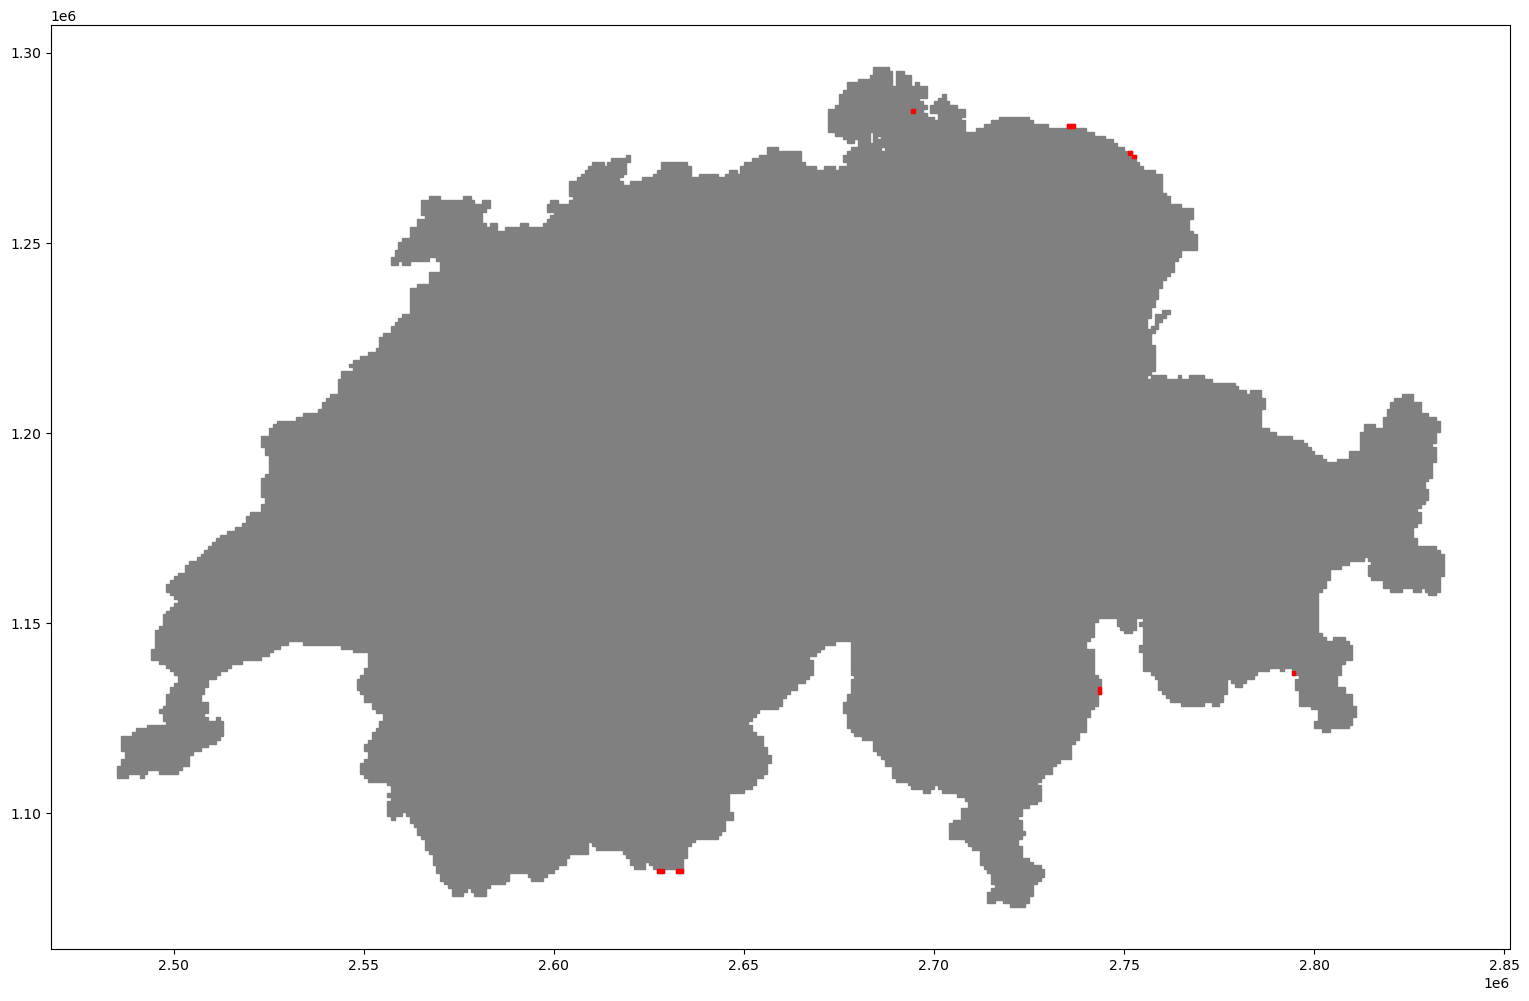

In [10]:
fig, ax = plt.subplots(figsize=(20, 12))

# Ajouter chaque polygone à l'axe avec la couleur basée sur la colonne
for idx, row in merged_gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="grey")

for idx, row in merged_gdf.loc[condition2].iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="red")

ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

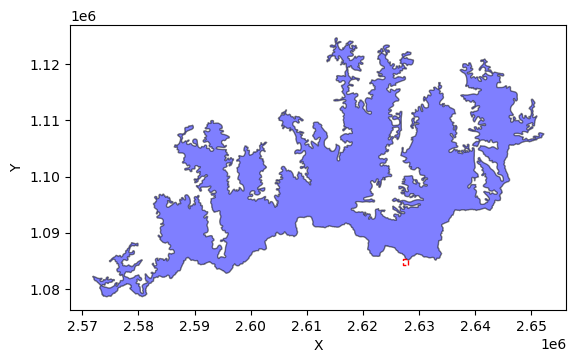

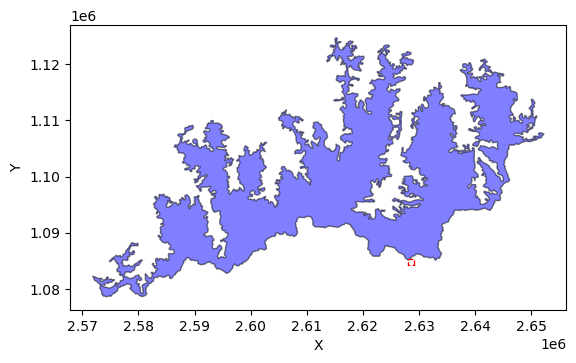

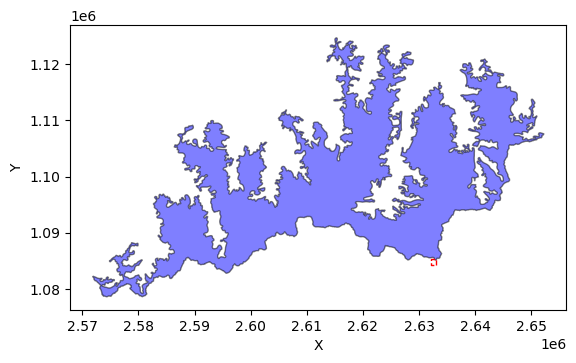

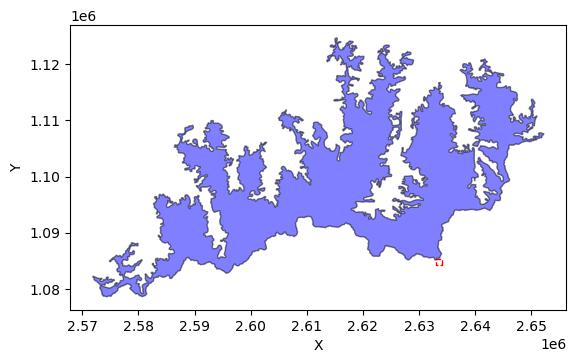

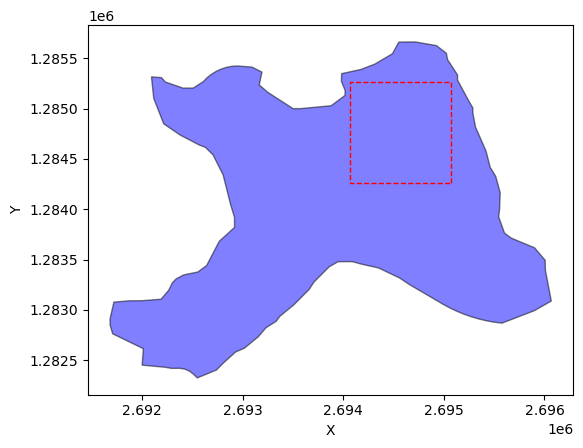

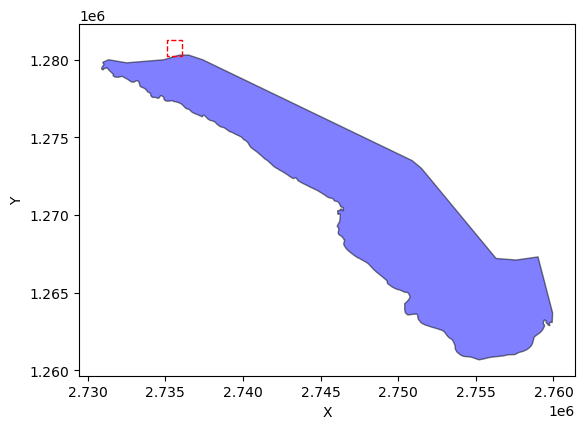

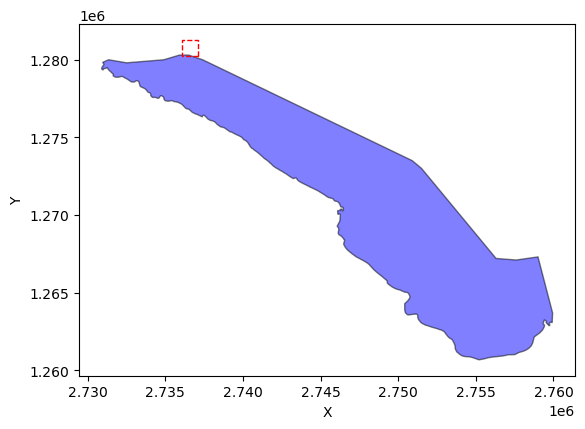

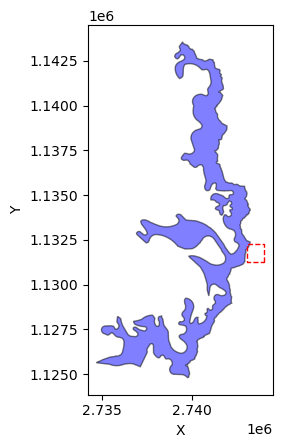

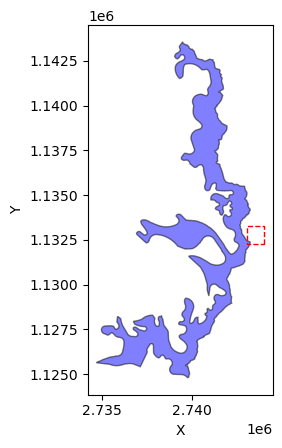

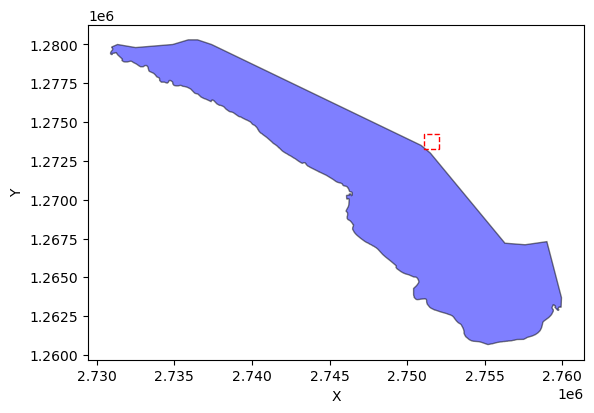

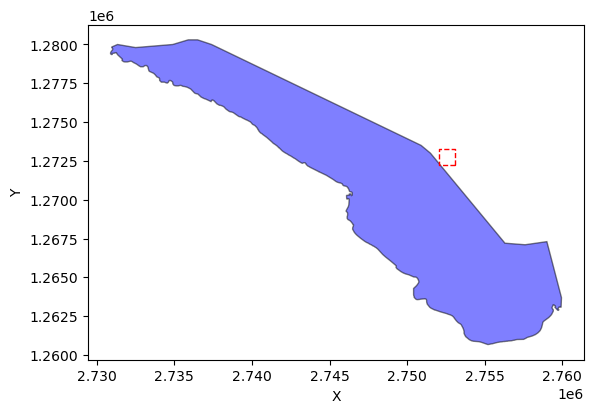

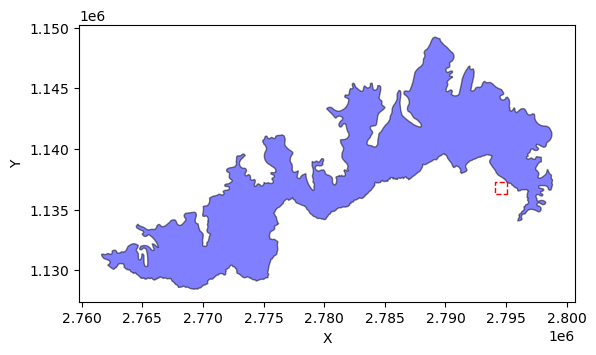

In [13]:
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon, box

# Choix de la couche à importer dans le notebook
selected_layer = "Bodeneignungskarte"
gdb_path = "data/raw/Bodeneignungskarte_LV95.gdb"


# Itérer sur les entrées du GeoDataFrame filtré
overlap_areas = []
for idx, row in merged_gdf.loc[condition2].iterrows():
    # Recherche de la zone associée à la geometrie
    bbox = row['geometry'].bounds
    gdf_perma = gpd.read_file(gdb_path, layer=selected_layer, bbox=bbox)

    # Définir la bounding box
    bbox_polygon = box(*bbox)
    
    # Créer une figure et un axe
    fig, ax = plt.subplots()
    
    # Ajouter chaque polygone à l'axe
    for polygon in gdf_perma['geometry'][0].geoms:
        x, y = polygon.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='blue', ec='black')
    
    # Ajouter la bounding box à l'axe
    x, y = bbox_polygon.exterior.xy
    ax.plot(x, y, color='red', linewidth=1, linestyle='--')
    
    # Configurer l'affichage
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal', adjustable='box')
    
    plt.show()


In [14]:
condition2 = (
   merged_gdf['geometry_env_drop'].isnull() & 
   (merged_gdf['Bodentyp'] == '-') & 
   (merged_gdf['NAHRSTOFF'] == -9999.0) & 
   (merged_gdf['WASSERDURC'] == -9999.0) &
   (merged_gdf['WASSERSPEI'] == -9999.0)
)

merged_gdf = merged_gdf.loc[~condition2]

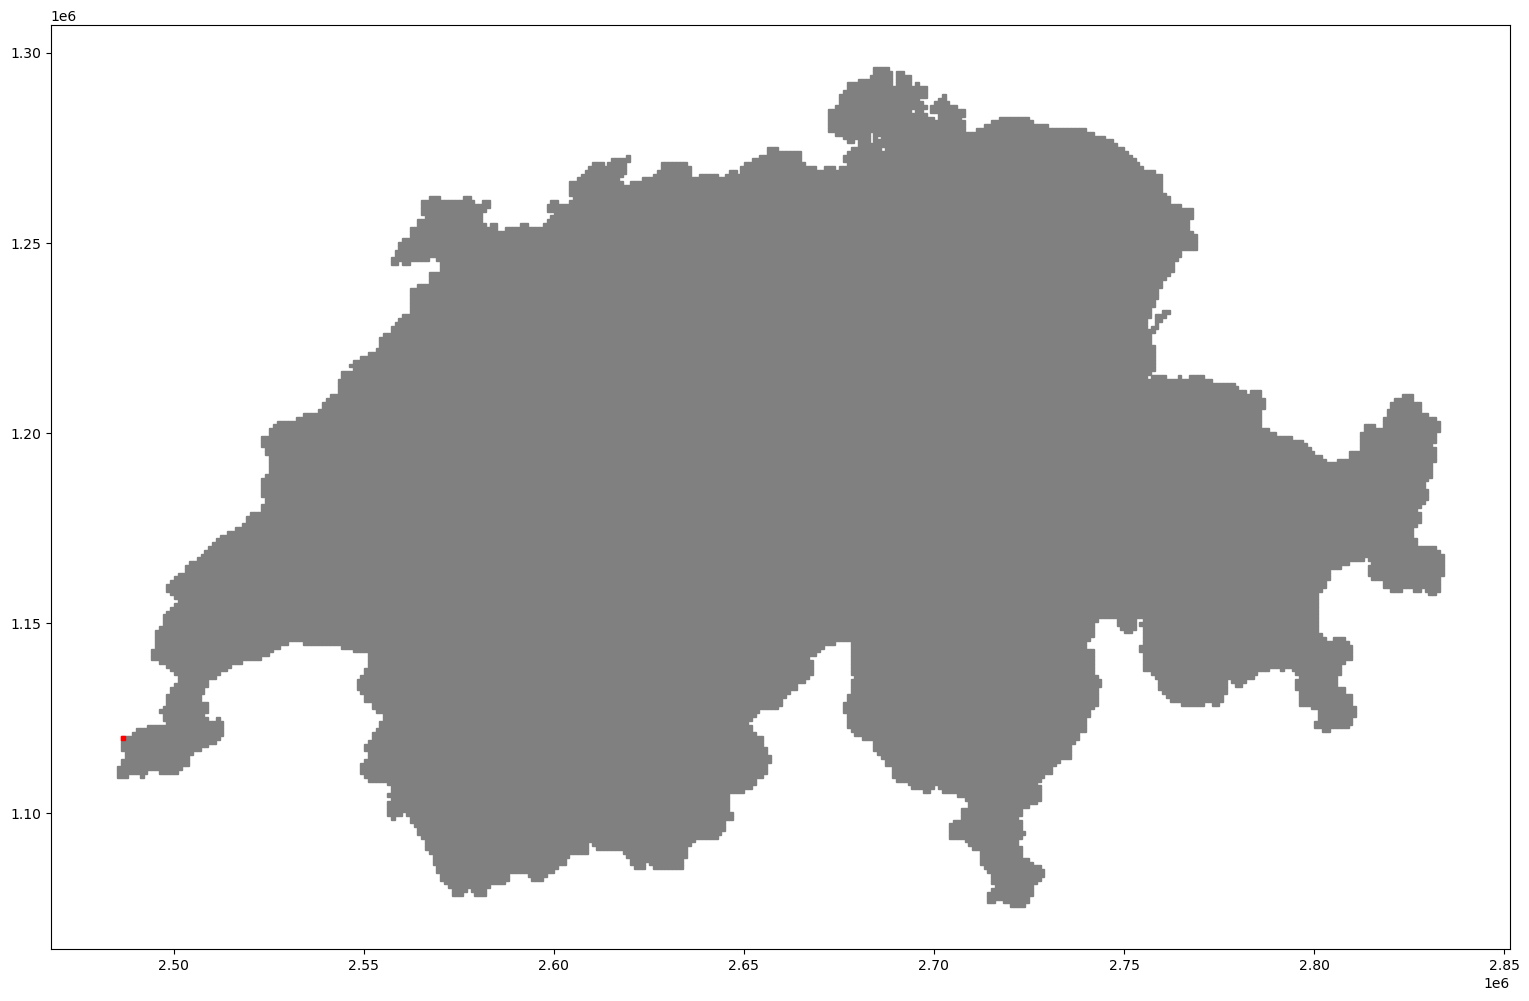

In [15]:
condition3 = (
    merged_gdf['geometry_env_drop'].isnull()    
)

fig, ax = plt.subplots(figsize=(20, 12))

# Ajouter chaque polygone à l'axe avec la couleur basée sur la colonne
for idx, row in merged_gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="grey")

for idx, row in merged_gdf.loc[condition3].iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="red")

ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

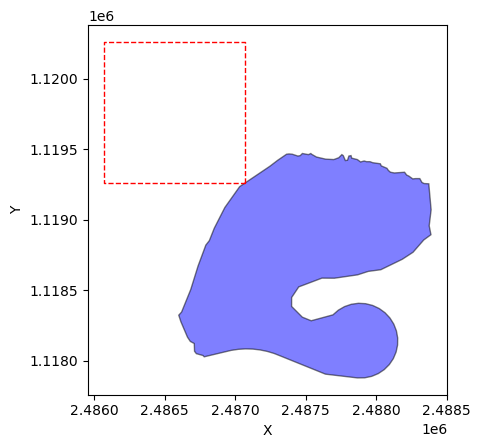

In [16]:
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon, box

# Choix de la couche à importer dans le notebook
selected_layer = "Bodeneignungskarte"
gdb_path = "data/raw/Bodeneignungskarte_LV95.gdb"


# Itérer sur les entrées du GeoDataFrame filtré
overlap_areas = []
for idx, row in merged_gdf.loc[condition3].iterrows():
    # Recherche de la zone associée à la geometrie
    bbox = row['geometry'].bounds
    gdf_perma = gpd.read_file(gdb_path, layer=selected_layer, bbox=bbox)

    # Définir la bounding box
    bbox_polygon = box(*bbox)
    
    # Créer une figure et un axe
    fig, ax = plt.subplots()
    
    # Ajouter chaque polygone à l'axe
    for polygon in gdf_perma['geometry'][0].geoms:
        x, y = polygon.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='blue', ec='black')
    
    # Ajouter la bounding box à l'axe
    x, y = bbox_polygon.exterior.xy
    ax.plot(x, y, color='red', linewidth=1, linestyle='--')
    
    # Configurer l'affichage
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal', adjustable='box')
    
    plt.show()


In [17]:
condition3 = (
    merged_gdf['geometry_env_drop'].isnull()
)

merged_gdf = merged_gdf.loc[~condition3]

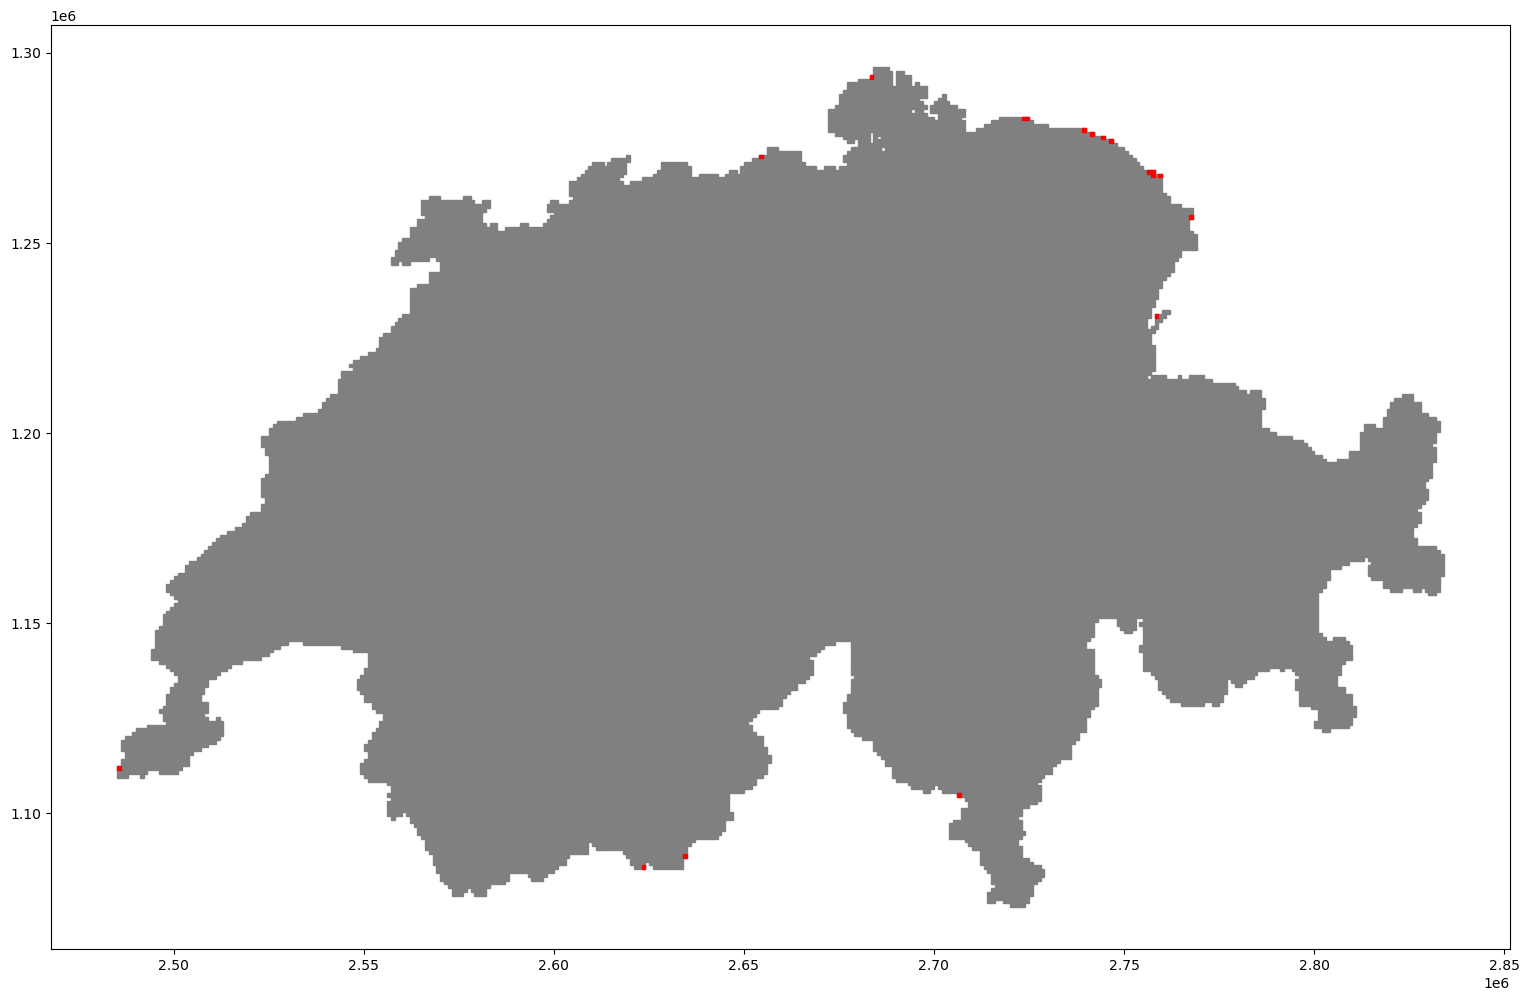

In [20]:
fig, ax = plt.subplots(figsize=(20, 12))

# Ajouter chaque polygone à l'axe avec la couleur basée sur la colonne
for idx, row in merged_gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="grey")

for idx, row in merged_gdf[merged_gdf.isnull().any(axis=1)].iterrows():
    if(row['TypoCH_NUM'] != 93) :
        polygon = row['geometry']
        x, y = polygon.exterior.xy
        ax.fill(x, y, color="red")

ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon, box

# Choix de la couche à importer dans le notebook
selected_layer = "Bodeneignungskarte"
gdb_path = "data/raw/Bodeneignungskarte_LV95.gdb"


# Itérer sur les entrées du GeoDataFrame filtré
overlap_areas = []
for idx, row in merged_gdf.loc[condition2].iterrows():
    # Recherche de la zone associée à la geometrie
    bbox = row['geometry'].bounds
    gdf_perma = gpd.read_file(gdb_path, layer=selected_layer, bbox=bbox)

    # Définir la bounding box
    bbox_polygon = box(*bbox)
    
    # Créer une figure et un axe
    fig, ax = plt.subplots()
    
    # Ajouter chaque polygone à l'axe
    for polygon in gdf_perma['geometry'][0].geoms:
        x, y = polygon.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='blue', ec='black')
    
    # Ajouter la bounding box à l'axe
    x, y = bbox_polygon.exterior.xy
    ax.plot(x, y, color='red', linewidth=1, linestyle='--')
    
    # Configurer l'affichage
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal', adjustable='box')
    
    plt.show()
